## Problem set 5

## Name: [TODO]

## Link to your PS5 github repo: [TODO]

### Problem 0 

-2 points for every missing green OK sign. 

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.10"):
    print(FAIL, "Python version 3.12.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "2.2.5", 'matplotlib': "3.10.1",'sklearn': "1.6.1", 
                'pandas': "2.2.3",'xgboost': "3.0.0", 'shap': "0.47.2", 
                'polars': "1.27.1", 'seaborn': "0.13.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.10

[ OK ] numpy version 2.2.5 is installed.
[ OK ] matplotlib version 3.10.1 is installed.
[ OK ] sklearn version 1.6.1 is installed.
[ OK ] pandas version 2.2.3 is installed.
[ OK ] xgboost version 3.0.0 is installed.
[ OK ] shap version 0.47.2 is installed.
[ OK ] polars version 1.27.1 is installed.
[ OK ] seaborn version 0.13.2 is installed.


### Problem 1

We will investigate the importance of preprocessing your dataset in this exercise. You will work with the unprocessed diabetes dataset in problem 1a, and you will preprocess it in 1b. You'll train a regression model in both problems and you'll compare the feature coefficients. This exercise is a preparation for one of the last topics we will cover in class: interpretability.

The coefficients of a linear model (the $w$'s) can be used to measure the importance of features if and only if all features have the same mean and standard deviation (even the one-hot encoded features!). Here is why:

The feature coefficients are determined by two things:
- the importance of the feautre
    - more important features have larger $w$'s
- the order of magnitude of the feature relative to the target variable
    - if a feature tends to be orders of magnitudes larger than the target variable, the feature's weight will be small in order to bring the feature to the same order of magnitude as the target variable 
    - similarly, if a feature tends to be orders of magnitudes smaller than the target variable, the feature's weight will be large in order to bring the feature to the same order of magnitude as the target variable 

This is an ambiguity since a feature could have a large $w$ because either it is important and/or because the feature values tend to be much smaller than the target variable.

The only way to remove this ambiguity is to standardize all features. If all features have the same mean and the same standard deviation (most commonly 0 mean and 1 standard deviation when you use the StandardScaler), all features have the same order of magnitudes. Then the feature coefficient is purely determined by the importance of the feature and it can be used to rank features based on how important they are.


### Problem 1a (10 points)

First, read in the dataset into a pandas dataframe using the tab delimited file linked at [this page](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Loop through 10 different random states. Split the dataset into training and test sets (70-30 ratios). We won't tune the regularization parameter, so we don't need a validation set for this exercise. Do not preprocess the sets. Train a linear regression model with Ridge regularization with alpha = 1. Use RMSE as your evaluation metric and print out the mean and standard deviation of the training and test scores. For each random state, save the test score and the model's coefficients for each feature.

Once you loop through the 10 random states, prepare one plot which shows the mean and standard deviation of each feature's coefficient. Make sure to have proper x and y ticks and labels, as well as a title.

Hint: use plt.errorbar() or something similar for the figure.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

URL = "https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt"
df = pd.read_csv(URL, sep="\t")
df

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [ ]:
target_col = "Y" if "Y" in df.columns else "y"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].values
y = df[target_col].values

### Loop 10 random states
random_states = list(range(10))

train_rmses = []
test_rmses = []
coef_runs = []  
rows_for_csv = []


for rs in random_states:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=rs
    )

    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    yhat_tr = model.predict(X_train)
    yhat_te = model.predict(X_test)
    rmse_tr = np.sqrt(mean_squared_error(y_train, yhat_tr))
    rmse_te = np.sqrt(mean_squared_error(y_test, yhat_te))

    train_rmses.append(rmse_tr)
    test_rmses.append(rmse_te)
    coef_runs.append(model.coef_.copy())

    row = {"random_state": rs, "rmse_train": rmse_tr, "rmse_test": rmse_te}
    row.update({f"coef_{f}": c for f, c in zip(feature_cols, model.coef_)})
    rows_for_csv.append(row)

print("Finished 10 runs.")

Finished 10 runs.


In [18]:
def mean_sd(a):
    return np.mean(a), np.std(a, ddof=1)

tr_mean, tr_sd = mean_sd(train_rmses)
te_mean, te_sd = mean_sd(test_rmses)

print(f"Training RMSE (mean ± sd): {tr_mean:.4f} ± {tr_sd:.4f}")
print(f"Test RMSE     (mean ± sd): {te_mean:.4f} ± {te_sd:.4f}")

results_df = pd.DataFrame(rows_for_csv)
results_df.to_csv("ridge_runs_diabetes.csv", index=False)
results_df.head()


Training RMSE (mean ± sd): 53.5631 ± 1.0137
Test RMSE     (mean ± sd): 53.8925 ± 2.5751


,random_state,rmse_train,rmse_test,coef_AGE,coef_SEX,coef_BMI,coef_BP,coef_S1,coef_S2,coef_S3,coef_S4,coef_S5,coef_S6
0,0,52.966228,55.697455,-0.185247,-18.193752,6.294161,0.939321,-0.476202,0.179801,-0.501642,2.731265,59.236027,0.120491
1,1,53.751446,53.272159,-0.043508,-22.318352,6.332460,1.188911,-0.673234,0.336051,0.087807,7.608542,54.020459,0.203513
2,2,53.496821,54.004901,-0.114264,-20.130720,4.859178,1.298256,-0.854470,0.593417,0.116496,5.982021,65.410342,0.243763
3,3,52.714641,55.788736,-0.001036,-27.031980,5.860316,1.132431,-0.549570,0.156803,-0.180407,8.252598,49.044142,0.426492
4,4,53.438339,54.400550,0.023796,-27.231702,4.691735,1.455805,-0.937586,0.560439,0.289883,8.638947,64.021482,0.187699


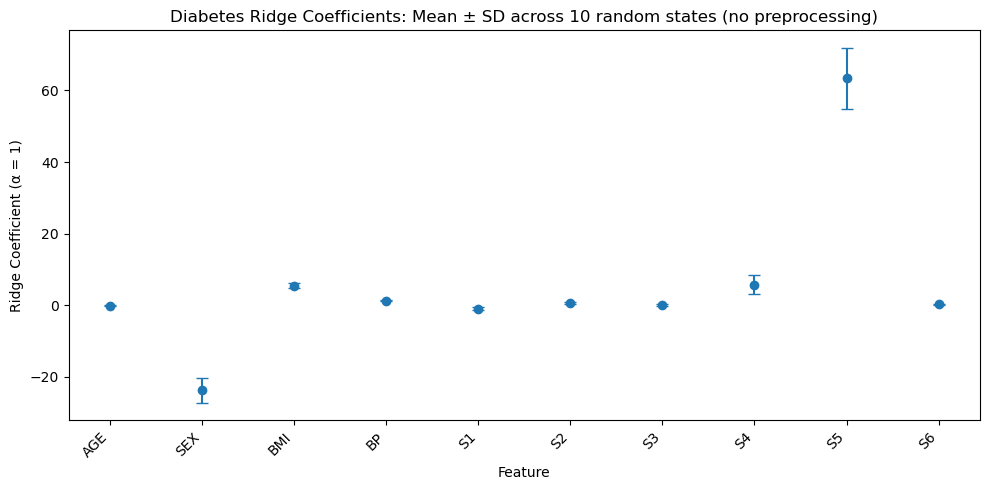

In [19]:
coef_mat = np.vstack(coef_runs)  
coef_mean = coef_mat.mean(axis=0)
coef_std = coef_mat.std(axis=0, ddof=1)

plt.figure(figsize=(10, 5))
x = np.arange(len(feature_cols))
plt.errorbar(x, coef_mean, yerr=coef_std, fmt='o', capsize=4)
plt.xticks(x, feature_cols, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Ridge Coefficient (α = 1)")
plt.title("Diabetes Ridge Coefficients: Mean ± SD across 10 random states (no preprocessing)")
plt.tight_layout()
plt.savefig("ridge_coefficients_mean_std.png", dpi=150)
plt.show()

### Problem 1b (10 points)

Now let's repeat what you did in 1a but this time preprocess the sets with the standard scaler.

Notice how the coefficients change as a result of preprocessing. 

Answer the following questions:

Q1: Do you see a statistically significant change in the test score?

Q2: How would you order the features based on the coefficients for feature importance? Explain your answer in a few sentences.

Q3: Print out names of the top 3 most important features!

In [ ]:
# your code here


**your answers here**

### Problem 2

In class we have seen both l1 (Lasso) and l2 (Ridge) regression. These are two basic ways to perform regularization. In the following problem, we will explore the **elastic net**, a third regularization technique that combines both l1 and l2 penalties. We will use this in a classification context. 

The basic idea of the elastic net is that the cost function in regression becomes

$L(\theta) = \frac{1}{n}\sum_{i=1}^{n}[(\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}- y_i)^2] + \color{red}{ \alpha \rho \sum_{j=0}^{m}|\theta_j|} + \color{blue}{ \alpha (1-\rho) \sqrt{\sum_{j=0}^{m} \theta_j^2}}$,

and the cost function in classification is

$L(\theta) = - \frac{1}{N}\sum_{i=1}^{n} [y_i\ln(\frac{1}{1+e^{-\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}}}) + (1-y_i)\ln(1-\frac{1}{1+e^{-\theta_0 + \sum_{j=1}^{m} \theta_j  x_{ij}}}))] + \color{red}{ \alpha \rho \sum_{j=0}^{m}|\theta_j|} + \color{blue}{ \alpha (1-\rho) \sqrt{\sum_{j=0}^{m} \theta_j^2}}$,


where $\alpha$ is the regularization parameter and $\rho$ is the l1 ratio (how much weight we assign to the l1 term over the l2 term in the cost function). Basically, an elastic net uses the weighted sum of the l1 and l2 regularization terms. The weight of the l1 term is $\rho$ and the weight of the l2 term is $(1-\rho)$ where $\rho$ is between 0 and 1.

You can read more about the elastic net [here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net).

Note that there are a large number of regularization techniques available in sklearn, the complete list of linear models are described [here](https://scikit-learn.org/stable/modules/linear_model.html).


### Problem 2a (3 points)

Load the training and validation sets from train.csv and val.csv from the `data` folder. 

Run a logistic regression model without regularization on the data and print the accuracy score of the validation set. Use the 'saga' solver. 

In [ ]:
# your code here 

### Problem 2b (7 points)

Perform l1 regularization on the data. 

The value of the alpha should contain 21 uniformly spaced values in log from 1e-2 to 1e2. 

Again, use the 'saga' solver and if you see a converge warning, fix it without ignoring the warning. 

Plot the train and validation accuracy scores. 

Print the best validation accuracy score and the corresponding alpha values.  If multiple alpha values give you euqlly good validation scores, print out all the alpha values, not just one.


In [ ]:
# your code here 

### Problem 2c (1 point)

Perform l2 regularization on the data. The alpha values and all the other instructions are the same as in 2b.

In [ ]:
# your code here 

### Problem 2d (10 points)

Let's train an elastic net now! The elastic net has two parameters: alpha and rho (the l1 ratio). The l1 ratio should be linearly spaced between 0 and 1 with 21 values in between, while alpha should be spaced as outlined above. (1 point) Use the 'saga' solver. The reason we use the saga solver everywhere in Problem 2 is that it is the only solver in LogisticRegression that works with an elastic net. 

Calculate the train and validation accuracy scores for all combinations of alpha and rho. 

Print the best validation score and the corresponding alpha and rho values. 

Prepare heatmaps to show the train and validation scores. Make sure that the data range covered by the two heatmaps are the same so you can easily compare the two heatmaps and you can identify the high bias and high variance regions. Label the plot and add a colorbar. Make the x and y ticks look pretty. 

Which of the four approaches gave you the best validation score?

In [ ]:
# your code here 